# **Analisis Hasil Data Scraping Proyek Fundamental Deep Learning**
- **Nama:** Muhammad Makarim
- **Email:** mmakarim9@student.ub.ac.id
- **ID Dicoding:** MC006D5Y1427

## **Import Semua Packages/Library yang Digunakan**

Pada Bagian ini akan dilakukan import library yang akan digunakan nantinya

In [1]:
!pip install Sastrawi

In [2]:
!pip install --quiet gdown

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import json
import requests
import pickle
import ast
import os
import gdown
import nltk

In [4]:
# Pastikan nltk package di-download
nltk.download('stopwords')
nltk.download('punkt', quiet=False)
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# Untuk analisis teks dan sentimen sederhana
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from ast import literal_eval

In [6]:
!pip install numpy==1.26.4

In [7]:
!pip install --no-deps tensorflow==2.18.0

In [8]:
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [9]:
import tensorflow as tf

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GRU, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# **Data Wrangling**

## **Memuat Dataset Ulasan Aplikasi WhatsApp (Gathring Data)**

Pada tahap ini, dataset berisi ulasan pengguna aplikasi WhatsApp dimuat dari file CSV. Dataset tersebut sebelumnya diperoleh melalui proses scraping dari Google Play Store dan disimpan dalam format CSV.

Dataset yang digunakan memiliki dua kolom utama:

1. `content`: memuat teks ulasan yang diberikan oleh pengguna.
2. `score`: memuat nilai rating yang diberikan oleh pengguna terhadap aplikasi, biasanya dengan rentang 1 hingga 5.

Setelah dimuat ke dalam variabel `data_frame`, beberapa baris pertama data ditampilkan untuk memberikan gambaran mengenai struktur dan isi dari dataset yang akan dianalisis.

In [115]:
file_id = '1ADt5Tvnf-39NOmy6m8tRAhegGoBpVFVx'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

output = 'whatsapp_reviews.csv'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ADt5Tvnf-39NOmy6m8tRAhegGoBpVFVx
From (redirected): https://drive.google.com/uc?export=download&id=1ADt5Tvnf-39NOmy6m8tRAhegGoBpVFVx&confirm=t&uuid=57bd770a-98dc-4f51-bc0c-74cde7ae322a
To: /content/whatsapp_reviews.csv
100%|██████████| 30.0M/30.0M [00:00<00:00, 57.6MB/s]


'whatsapp_reviews.csv'

In [116]:
df = pd.read_csv(output)
df.head()

,content,score
0,jauh lebih bagus dari update kemarin 👍,4
1,Cukup baik,2
2,"Sedang di instal mudah"" lancar.",2
3,Segala urusan jadi mudah,5
4,"didownload ulang ga bisa,padahal apk nya yg g ...",1


In [117]:
print(df.shape)

(607500, 2)


In [118]:
# Mengambil sampel acak 20 ribu baris dari DataFrame df tanpa pengembalian
df_sample = df.sample(n=20000, random_state=42)

In [119]:
df_sample.head()

,content,score
373463,Tambahin fitur keamanannnya dong bang operator,2
131890,Sangat baik,3
556374,whatsapp sangat membantu saya dalam berkomunikasi,5
20538,Top,4
69917,Ok,5


In [120]:
print(df_sample.shape)

(20000, 2)


In [132]:
df_sample.to_csv('whatsapp_reviews_sample.csv', index=False)

## **Assessing Data**

In [121]:
print(df_sample.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 373463 to 24634
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB
None


In [122]:
print(df_sample.describe())

              score
count  20000.000000
mean       3.813850
std        1.613204
min        1.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        5.000000


## **Cleaning Data**

In [123]:
#Mengecek missing value
missing_values = df_sample.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Series([], dtype: int64)


In [124]:
df_sample.dropna(axis=0, inplace=True)

In [125]:
print("Sudah tidak ada data yang hilang?", df_sample.isnull().sum().sum() == 0)

Sudah tidak ada data yang hilang? True


In [126]:
# cek ulang missing values
print("\nMissing Values setelah dilakukan cleaning:")
print(df_sample.isnull().sum())


Missing Values setelah dilakukan cleaning:
content    0
score      0
dtype: int64


**Insight**
1.   Sudah tidak ada missing value ditemukan pada dataset
2.   Seluruh kolom yang mempunyai missing value akan di drop menggunakan `dropna()`

# **Exploratory Data Analysis (EDA)**

### **Cek informasi dasar dataset**

In [23]:
# Melihat info tipe data dan keberadaan missing value
print(df_sample.info())

# Melihat statistik deskriptif untuk kolom numerik (score)
print(df_sample['score'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 373463 to 24634
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB
None
count    20000.000000
mean         3.813850
std          1.613204
min          1.000000
25%          2.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: score, dtype: float64


In [24]:
print("\nMissing Values setelah dilakukan cleaning:")
print(df_sample.isnull().sum())


Missing Values setelah dilakukan cleaning:
content    0
score      0
dtype: int64


<ipython-input-25-d5e3b6d57d05>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df_sample, palette='muted')


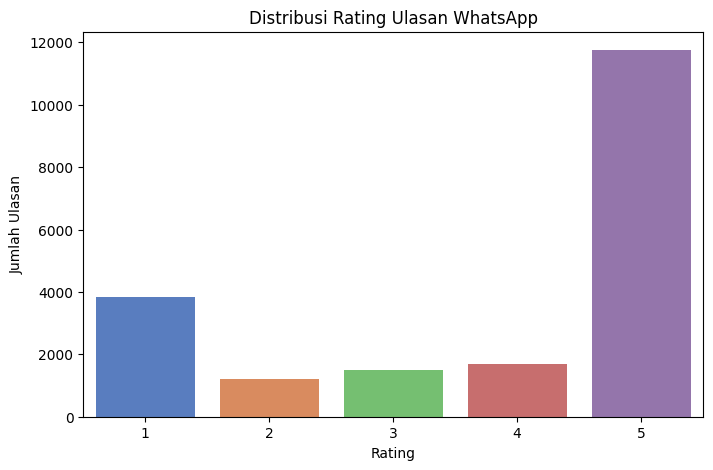

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(x='score', data=df_sample, palette='muted')
plt.title('Distribusi Rating Ulasan WhatsApp')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

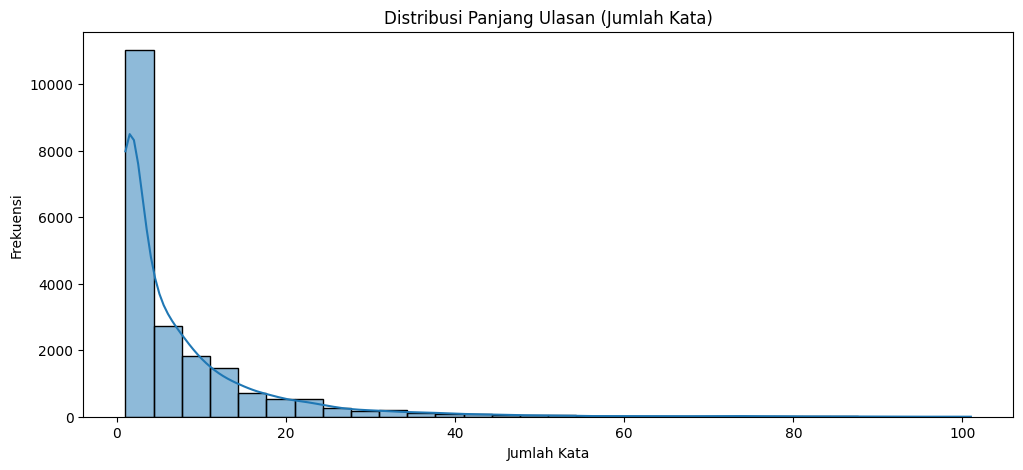

In [26]:
# Hitung jumlah kata per ulasan
df_sample['word_count'] = df_sample['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))
sns.histplot(df_sample['word_count'], bins=30, kde=True)
plt.title('Distribusi Panjang Ulasan (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

# **Text Preprocessing**

### **Fungsi Untuk Membersihkan Teks Ulasan**

Tahapan ini merupakan langkah awal dalam preprocessing teks ulasan. Tujuannya adalah untuk membersihkan dan menyeragamkan teks sehingga lebih siap untuk analisis sentimen atau pemodelan machine learning.

In [27]:
def proses_teks(teks):
    # Hapus mention (@username)
    teks = re.sub(r'@\w+', '', teks)
    # Hapus hashtag (#hashtag)
    teks = re.sub(r'#\w+', '', teks)
    # Hapus karakter khusus tertentu (misal simbol²)
    teks = re.sub(r'[²]', '', teks)
    # Hapus angka
    teks = re.sub(r'\d+', '', teks)
    # Hapus tanda baca
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    # Hapus spasi lebih dari 1 dan trim spasi di awal/akhir
    teks = re.sub(r'\s+', ' ', teks).strip()

    return teks

df_sample['clean_content'] = df_sample['content'].apply(proses_teks)

### **Case Folding**

In [28]:
def casefoldingText(teks):
    return str(teks).lower()

df_sample['casefold_content'] = df_sample['clean_content'].apply(casefoldingText)

print(df_sample[['clean_content', 'casefold_content']].head())

                                            clean_content  \
373463     Tambahin fitur keamanannnya dong bang operator   
131890                                        Sangat baik   
556374  whatsapp sangat membantu saya dalam berkomunikasi   
20538                                                 Top   
69917                                                  Ok   

                                         casefold_content  
373463     tambahin fitur keamanannnya dong bang operator  
131890                                        sangat baik  
556374  whatsapp sangat membantu saya dalam berkomunikasi  
20538                                                 top  
69917                                                  ok  


### **Fungsi Tokenisasi Teks**

In [29]:
# Fungsi tokenizing, menerima input teks string, output list token kata
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

def tokenizing(teks):
    return word_tokenize(teks)

# Terapkan tokenizing pada kolom casefold_content
df_sample['tokens'] = df_sample['casefold_content'].apply(tokenizing)

# Contoh tampilkan hasil tokenizing
print(df_sample[['casefold_content', 'tokens']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                         casefold_content  \
373463     tambahin fitur keamanannnya dong bang operator   
131890                                        sangat baik   
556374  whatsapp sangat membantu saya dalam berkomunikasi   
20538                                                 top   
69917                                                  ok   

                                                   tokens  
373463  [tambahin, fitur, keamanannnya, dong, bang, op...  
131890                                     [sangat, baik]  
556374  [whatsapp, sangat, membantu, saya, dalam, berk...  
20538                                               [top]  
69917                                                [ok]  


### **Stemming**

In [30]:
# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming setiap token dalam list
def stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

# Terapkan proses stemming pada kolom 'tokens'
df_sample['stemmed_tokens'] = df_sample['tokens'].apply(stemming)

# Tampilkan contoh hasil stemming
print(df_sample[['tokens', 'stemmed_tokens']].head())

                                                   tokens  \
373463  [tambahin, fitur, keamanannnya, dong, bang, op...   
131890                                     [sangat, baik]   
556374  [whatsapp, sangat, membantu, saya, dalam, berk...   
20538                                               [top]   
69917                                                [ok]   

                                           stemmed_tokens  
373463  [tambahin, fitur, keamanannnya, dong, bang, op...  
131890                                     [sangat, baik]  
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...  
20538                                               [top]  
69917                                                [ok]  


### **Negation Handling**

In [31]:
def negation_handling(stemmed_tokens):
    negation_words = {'tidak', 'jangan', 'bukan', 'belum'}
    hasil = []
    skip_next = False
    for i in range(len(stemmed_tokens)):
        if skip_next:
            skip_next = False
            continue

        token = stemmed_tokens[i]
        if token in negation_words and i+1 < len(stemmed_tokens):
            # Gabungkan kata negasi dengan kata setelahnya
            combined = token + '_' + stemmed_tokens[i+1]
            hasil.append(combined)
            skip_next = True  # lewati kata berikutnya karena sudah digabung
        else:
            hasil.append(token)
    return hasil

# Terapkan pada kolom stemmed_tokens
df_sample['tokens_negation'] = df_sample['stemmed_tokens'].apply(negation_handling)

# Contoh lihat hasilnya
print(df_sample[['stemmed_tokens', 'tokens_negation']].head())

                                           stemmed_tokens  \
373463  [tambahin, fitur, keamanannnya, dong, bang, op...   
131890                                     [sangat, baik]   
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...   
20538                                               [top]   
69917                                                [ok]   

                                          tokens_negation  
373463  [tambahin, fitur, keamanannnya, dong, bang, op...  
131890                                     [sangat, baik]  
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...  
20538                                               [top]  
69917                                                [ok]  


### **Word Normalization**

In [32]:
def convertToSlangword(tokens_negation):
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in tokens_negation:
        filter_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata.lower())
        if filter_slang.startswith('tidak_'):
          kata_depan = 'tidak_'
          kata_belakang = kata[6:]
          kata_belakang_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata_belakang.lower())
          kata_hasil = kata_depan + kata_belakang_slang
          content.append(kata_hasil)
        else:
          content.append(filter_slang)
    ulasan = content
    return ulasan

df_sample['tokens_slang'] = df_sample['tokens_negation'].apply(convertToSlangword)

# Contoh lihat hasilnya
print(df_sample[['tokens_negation', 'tokens_slang']].head())

                                          tokens_negation  \
373463  [tambahin, fitur, keamanannnya, dong, bang, op...   
131890                                     [sangat, baik]   
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...   
20538                                               [top]   
69917                                                [ok]   

                                             tokens_slang  
373463  [tambah, fitur, keamanannnya, dong, bang, oper...  
131890                                     [sangat, baik]  
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...  
20538                                               [top]  
69917                                                [ok]  


### **Fungsi Penghapusan Stopwords**

In [33]:
def hapus_stopwords(tokens_slang):
    stop_words = set(stopwords.words('indonesian'))
    stop_words_english = set(stopwords.words('english'))

    stop_words.update(stop_words_english)
    stop_words.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy'
    ])
    hasil_hapus = [kata for kata in tokens_slang if kata not in stop_words]
    return hasil_hapus
df_sample['stopword_removal'] = df_sample['tokens_slang'].apply(hapus_stopwords)

# Contoh lihat hasilnya
print(df_sample[['tokens_slang', 'stopword_removal']].head())

                                             tokens_slang  \
373463  [tambah, fitur, keamanannnya, dong, bang, oper...   
131890                                     [sangat, baik]   
556374  [whatsapp, sangat, bantu, saya, dalam, komunik...   
20538                                               [top]   
69917                                                [ok]   

                             stopword_removal  
373463  [fitur, keamanannnya, bang, operator]  
131890                                     []  
556374          [whatsapp, bantu, komunikasi]  
20538                                   [top]  
69917                                    [ok]  


In [34]:
df_sample.to_csv('data_bersih.csv', index=False)

### **Pelabelan Menggunakan Lexikon**

In [35]:
df_bersih = pd.read_csv('data_bersih.csv')

In [36]:
print("\nMissing Values setelah dilakukan cleaning:")
print(df_bersih.isnull().sum())


Missing Values setelah dilakukan cleaning:
content             0
score               0
word_count          0
clean_content       4
casefold_content    4
tokens              0
stemmed_tokens      0
tokens_negation     0
tokens_slang        0
stopword_removal    0
dtype: int64


In [37]:
df_bersih.dropna(axis=0, inplace=True)

In [38]:
print("\nMissing Values setelah dilakukan cleaning:")
print(df_bersih.isnull().sum())


Missing Values setelah dilakukan cleaning:
content             0
score               0
word_count          0
clean_content       0
casefold_content    0
tokens              0
stemmed_tokens      0
tokens_negation     0
tokens_slang        0
stopword_removal    0
dtype: int64


In [39]:
df_bersih.head()

,content,score,word_count,clean_content,casefold_content,tokens,stemmed_tokens,tokens_negation,tokens_slang,stopword_removal
0,Tambahin fitur keamanannnya dong bang operator,2,6,Tambahin fitur keamanannnya dong bang operator,tambahin fitur keamanannnya dong bang operator,"['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambah', 'fitur', 'keamanannnya', 'dong', 'b...","['fitur', 'keamanannnya', 'bang', 'operator']"
1,Sangat baik,3,2,Sangat baik,sangat baik,"['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']",[]
2,whatsapp sangat membantu saya dalam berkomunikasi,5,6,whatsapp sangat membantu saya dalam berkomunikasi,whatsapp sangat membantu saya dalam berkomunikasi,"['whatsapp', 'sangat', 'membantu', 'saya', 'da...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'bantu', 'komunikasi']"
3,Top,4,1,Top,top,['top'],['top'],['top'],['top'],['top']
4,Ok,5,1,Ok,ok,['ok'],['ok'],['ok'],['ok'],['ok']


In [40]:
df_bersih['stopword_removal'] = df_bersih['stopword_removal'].apply(ast.literal_eval)

In [41]:
#Mengakses csv data word positive dan negative
df_positive = pd.read_csv('positive.csv', header=0, sep='\t', encoding='utf-8')
df_negative = pd.read_csv('negative.csv', header=0, sep='\t', encoding='utf-8')

In [42]:
#Menampilkan data kata-kata negative
df_negative.head()

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5


In [43]:
#Menampilkan data kata-kata positive
df_positive.head()

,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2


In [44]:
#Cleaning dataset kata positive dan negative
positive_words = set(df_positive['word'].str.strip().dropna())
negative_words = set(df_negative['word'].str.strip().dropna())

In [45]:
# Fungsi pelabelan sentimen dengan skor lexikon
def lexicon_sentiment_scoring(token_list):
    score = 0
    for token in token_list:
        if token in positive_words:
            score += 1
        elif token in negative_words:
            score -= 1
    if score > 0:
        label = 'positif'
    elif score < 0:
        label = 'negatif'
    else:
        label = 'netral'
    return label, score

df_bersih['sentiment_result'] = df_bersih['stopword_removal'].apply(lexicon_sentiment_scoring)
df_bersih[['sentiment_label', 'sentiment_score']] = pd.DataFrame(df_bersih['sentiment_result'].tolist(), index=df_bersih.index)
df_bersih.drop(columns=['sentiment_result'], inplace=True)
df_bersih.to_csv('data_bersih_berlabel.csv', index=False, encoding='utf-8')

print("Pelabelan sentimen selesai dan disimpan pada 'data_bersih_berlabel.csv'")

Pelabelan sentimen selesai dan disimpan pada 'data_bersih_berlabel.csv'


In [46]:
ulasan = pd.read_csv('data_bersih_berlabel.csv')

In [47]:
print("\nMissing Values setelah dilakukan cleaning:")
print(ulasan.isnull().sum())


Missing Values setelah dilakukan cleaning:
content             0
score               0
word_count          0
clean_content       0
casefold_content    0
tokens              0
stemmed_tokens      0
tokens_negation     0
tokens_slang        0
stopword_removal    0
sentiment_label     0
sentiment_score     0
dtype: int64


In [48]:
ulasan.head()

,content,score,word_count,clean_content,casefold_content,tokens,stemmed_tokens,tokens_negation,tokens_slang,stopword_removal,sentiment_label,sentiment_score
0,Tambahin fitur keamanannnya dong bang operator,2,6,Tambahin fitur keamanannnya dong bang operator,tambahin fitur keamanannnya dong bang operator,"['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambah', 'fitur', 'keamanannnya', 'dong', 'b...","['fitur', 'keamanannnya', 'bang', 'operator']",netral,0
1,Sangat baik,3,2,Sangat baik,sangat baik,"['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']",[],netral,0
2,whatsapp sangat membantu saya dalam berkomunikasi,5,6,whatsapp sangat membantu saya dalam berkomunikasi,whatsapp sangat membantu saya dalam berkomunikasi,"['whatsapp', 'sangat', 'membantu', 'saya', 'da...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'bantu', 'komunikasi']",positif,2
3,Top,4,1,Top,top,['top'],['top'],['top'],['top'],['top'],positif,1
4,Ok,5,1,Ok,ok,['ok'],['ok'],['ok'],['ok'],['ok'],positif,1


In [49]:
ulasan['sentiment_label'].value_counts()

,count
sentiment_label,
positif,12365
netral,5610
negatif,2021


### **Visualisasi Distribusi Sentimen Ulasan WhatsApp**

jumlah sentimen :
sentiment_label
positif    12365
netral      5610
negatif     2021
Name: count, dtype: int64


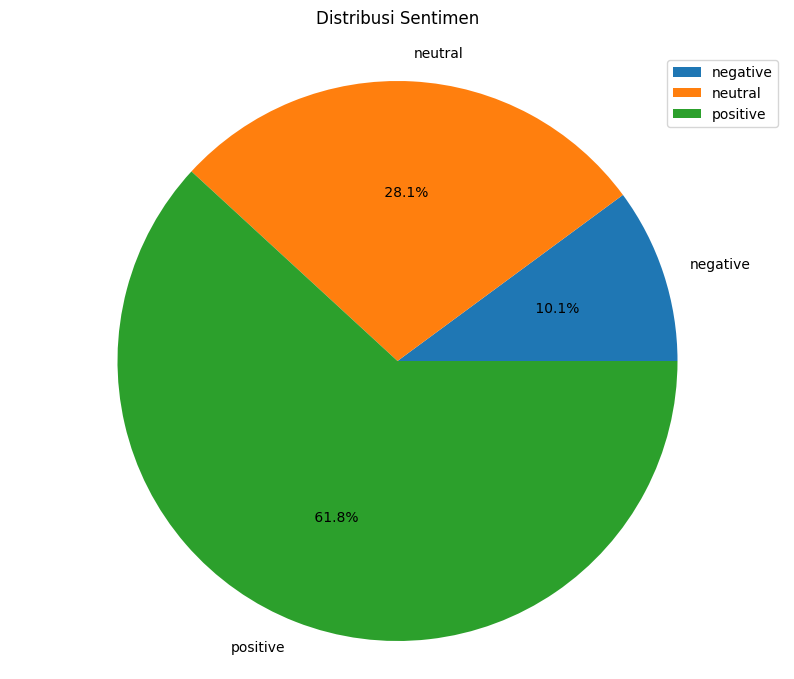

In [128]:
# melihat jumlah kelas sentimen
Jumlah_sentimen = ulasan['sentiment_label'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)

# menampilkan dalam bentuk plot diagram
%matplotlib inline
labels = ['negative' , 'neutral', 'positive']
plt.figure(figsize=(10, 8))
plt.pie(ulasan.groupby('sentiment_label')['sentiment_label'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.axis('equal')
plt.title('Distribusi Sentimen\n')
plt.show()

### **Visualisasi Histogram Skor Sentimen**

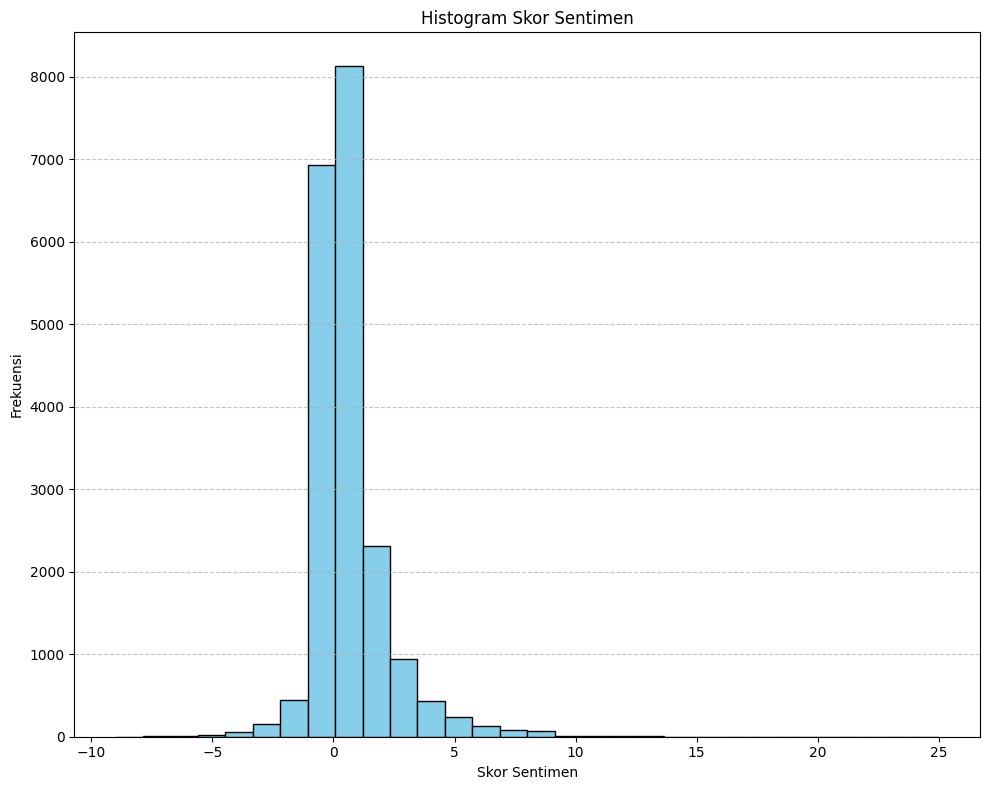

In [51]:
plt.figure(figsize=(10,8))
plt.hist(ulasan['sentiment_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Skor Sentimen')
plt.xlabel('Skor Sentimen')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

# **Data Preparation**

In [52]:
# Tangani nilai NaN
ulasan['stopword_removal'] = ulasan['stopword_removal'].fillna('')

In [53]:
max_features = 10000  # Tingkatkan jumlah kata
tokenizer = Tokenizer(num_words=max_features, oov_token="<unk>") # Tambahkan oov_token
tokenizer.fit_on_texts(ulasan['stopword_removal'])

In [54]:
sequences = tokenizer.texts_to_sequences(ulasan['stopword_removal'])

In [55]:
max_length = 100  # Eksperimen dengan panjang sequence
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [56]:
# Pilih fitur (teks ulasan) dan target (label sentimen)
fitur = ulasan['stopword_removal']
label = ulasan['sentiment_label'].map({'positif': 2, 'netral': 1, 'negatif': 0})

# **Feature Engineering**

## **TF-IDF**

In [57]:
# Transformasi teks ke vektor angka menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
fitur_tfidf = tfidf.fit_transform(fitur)

# Menampilkan dimensi data hasil vektorisasi
print("Ringkasan Fitur dan Data:")
print(f"Dimensi fitur TF-IDF: {fitur_tfidf.shape}")

Ringkasan Fitur dan Data:
Dimensi fitur TF-IDF: (19996, 10000)


## **SVM x TF-IDF (80/20)**

### **Praprocessing Teks untuk Model SVM Menggunakan TF-IDF (80/20)**

Menggunakan Support Vector Machine (SVM). Dengan pembagian data (80/20), 80 untuk data training dan 20 persen untuk data testing. Sebelum kita latih model ini kita pisahkan sesuai ketentuan yaitu 80/20

In [58]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
fitur_train_svm, fitur_test_svm, label_train_svm, label_test_svm = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {fitur_train_svm.shape[0]} sampel")
print(f"Set pengujian: {fitur_test_svm.shape[0]} sampel")

Total Sampel:
Set pelatihan: 15996 sampel
Set pengujian: 4000 sampel


### **Pelatihan dan Prediksi Model SVM**

In [59]:
# Inisialisasi Model SVM dengan Kernel Linear
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(fitur_train_svm, label_train_svm)
label_pred_svm = svm_model.predict(fitur_test_svm)

accuracy_svm = accuracy_score(label_test_svm, label_pred_svm)
print(f"Akurasi SVM: {accuracy_svm}")
print(classification_report(label_test_svm, label_pred_svm))

Akurasi SVM: 0.9375
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       419
           1       0.86      0.94      0.90      1107
           2       0.98      0.97      0.98      2474

    accuracy                           0.94      4000
   macro avg       0.92      0.88      0.90      4000
weighted avg       0.94      0.94      0.94      4000



### **Evaluasi Model SVM Berbasis TF-IDF**

Akurasi Training SVM: 0.9806201550387597
Akurasi Testing SVM: 0.9375
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       419
           1       0.86      0.94      0.90      1107
           2       0.98      0.97      0.98      2474

    accuracy                           0.94      4000
   macro avg       0.92      0.88      0.90      4000
weighted avg       0.94      0.94      0.94      4000



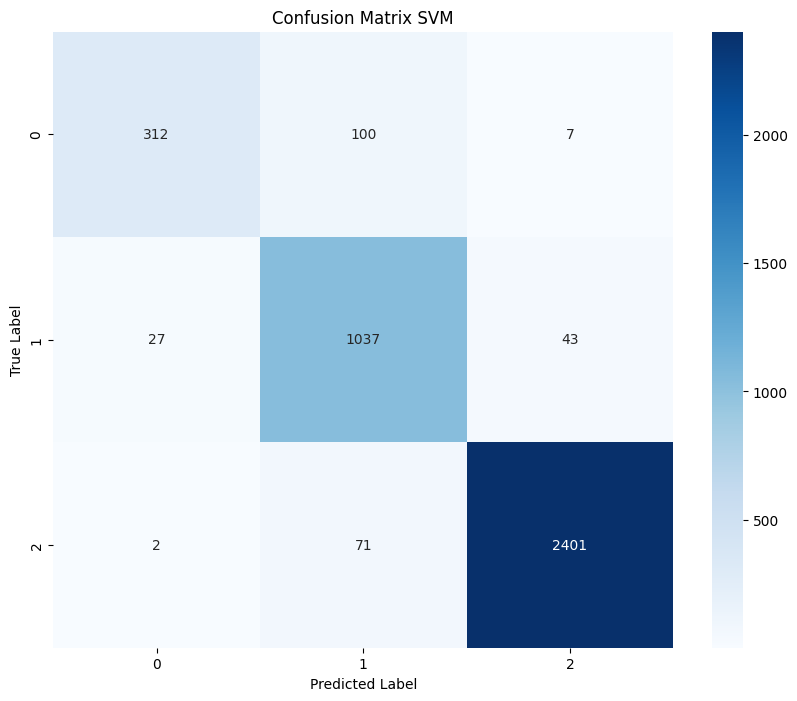

In [60]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(fitur_train_svm, label_train_svm)
label_pred_svm = svm_model.predict(fitur_test_svm)

# Evaluasi pada data training
label_pred_train_svm = svm_model.predict(fitur_train_svm)
accuracy_train_svm = accuracy_score(label_train_svm, label_pred_train_svm)
print(f"Akurasi Training SVM: {accuracy_train_svm}")

# Evaluasi pada data testing
accuracy_svm = accuracy_score(label_test_svm, label_pred_svm)
print(f"Akurasi Testing SVM: {accuracy_svm}")
print("Classification Report SVM:")
print(classification_report(label_test_svm, label_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(label_test_svm, label_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## **SVM x TF-IDF (60/40)**

### **Praprocessing Teks untuk Model SVM Menggunakan TF-IDF (60/40)**

In [61]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
fitur_train_svm2, fitur_test_svm2, label_train_svm2, label_test_svm2 = train_test_split(fitur_tfidf, label, test_size=0.4, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {fitur_train_svm2.shape[0]} sampel")
print(f"Set pengujian: {fitur_test_svm2.shape[0]} sampel")

Total Sampel:
Set pelatihan: 11997 sampel
Set pengujian: 7999 sampel


### **Pelatihan dan Prediksi Model SVM**

In [62]:
# Inisialisasi Model SVM dengan Kernel Linear
svm_model2 = SVC(kernel='linear', C=1)
svm_model2.fit(fitur_train_svm2, label_train_svm2)
label_pred_svm2 = svm_model2.predict(fitur_test_svm2)

accuracy_svm2 = accuracy_score(label_test_svm2, label_pred_svm2)
print(f"Akurasi SVM: {accuracy_svm2}")
print(classification_report(label_test_svm2, label_pred_svm2))

Akurasi SVM: 0.9262407800975122
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       815
           1       0.84      0.92      0.88      2233
           2       0.98      0.96      0.97      4951

    accuracy                           0.93      7999
   macro avg       0.90      0.87      0.88      7999
weighted avg       0.93      0.93      0.93      7999



### **Evaluasi Model SVM Berbasis TF-IDF**

Akurasi Training SVM: 0.9777444361090273
Akurasi Testing SVM: 0.9587448431053882
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       815
           1       0.91      0.95      0.93      2233
           2       0.99      0.98      0.98      4951

    accuracy                           0.96      7999
   macro avg       0.94      0.92      0.93      7999
weighted avg       0.96      0.96      0.96      7999



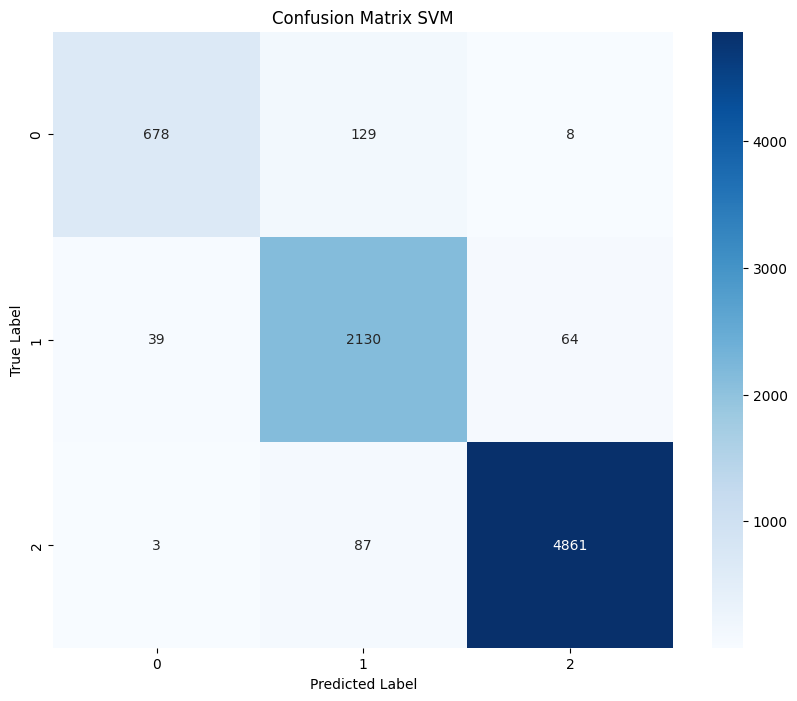

In [63]:
svm_model2 = SVC(kernel='linear', C=1)
svm_model2.fit(fitur_train_svm2, label_train_svm2)
label_pred_svm2 = svm_model.predict(fitur_test_svm2)

# Evaluasi pada data training
label_pred_train_svm2 = svm_model2.predict(fitur_train_svm2)
accuracy_train_svm2 = accuracy_score(label_train_svm2, label_pred_train_svm2)
print(f"Akurasi Training SVM: {accuracy_train_svm2}")

# Evaluasi pada data testing
accuracy_svm2 = accuracy_score(label_test_svm2, label_pred_svm2)
print(f"Akurasi Testing SVM: {accuracy_svm2}")
print("Classification Report SVM:")
print(classification_report(label_test_svm2, label_pred_svm2))

# Confusion Matrix
cm_svm2 = confusion_matrix(label_test_svm2, label_pred_svm2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **RF x TF-IDF (70/30)**

### **Praprocessing Teks untuk Model RF Menggunakan TF-IDF (70/30)**

In [64]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
fitur_train_rf, fitur_test_rf, label_train_rf, label_test_rf = train_test_split(fitur_tfidf, label, test_size=0.3, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {fitur_train_rf.shape[0]} sampel")
print(f"Set pengujian: {fitur_test_rf.shape[0]} sampel")

Total Sampel:
Set pelatihan: 13997 sampel
Set pengujian: 5999 sampel


### **Pelatihan dan Prediksi Model RF**

In [65]:
#Inisialisasi dan latih model Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(fitur_train_rf, label_train_rf)

# 7. Prediksi label pada data testing
label_pred_rf = rf_model.predict(fitur_test_rf)

### **Evaluasi Model Random Forest dengan TF-IDF**

Akurasi Training Random Forest: 0.8888333214260199
Classification Report Training Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1395
           1       0.85      0.80      0.82      3943
           2       0.90      0.97      0.94      8659

    accuracy                           0.89     13997
   macro avg       0.89      0.80      0.83     13997
weighted avg       0.89      0.89      0.88     13997

Akurasi Testing Random Forest: 0.8688114685780963
Classification Report Testing Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       626
           1       0.83      0.77      0.80      1667
           2       0.89      0.97      0.93      3706

    accuracy                           0.87      5999
   macro avg       0.85      0.76      0.79      5999
weighted avg       0.87      0.87      0.86      5999



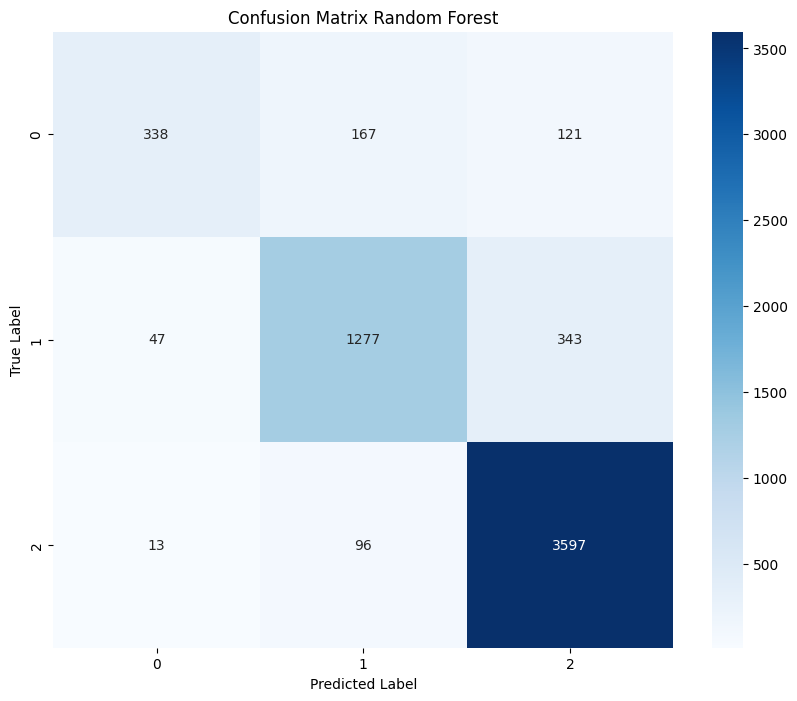

In [66]:
label_pred_rf = rf_model.predict(fitur_test_rf)
label_pred_train_rf = rf_model.predict(fitur_train_rf)

# Evaluasi pada data training
accuracy_train_rf = accuracy_score(label_train_rf, label_pred_train_rf)
print(f"Akurasi Training Random Forest: {accuracy_train_rf}")
print("Classification Report Training Random Forest:")
print(classification_report(label_train_rf, label_pred_train_rf))

# Evaluasi pada data testing
accuracy_rf = accuracy_score(label_test_rf, label_pred_rf)
print(f"Akurasi Testing Random Forest: {accuracy_rf}")
print("Classification Report Testing Random Forest:")
print(classification_report(label_test_rf, label_pred_rf))

# Membuat Confusion Matrix
cm_rf = confusion_matrix(label_test_rf, label_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **RF x TF-IDF (80/20)**

### **Praprocessing Teks untuk Model RF Menggunakan TF-IDF (80/20)**

In [67]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
fitur_train_rf2, fitur_test_rf2, label_train_rf2, label_test_rf2 = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {fitur_train_rf2.shape[0]} sampel")
print(f"Set pengujian: {fitur_test_rf2.shape[0]} sampel")

Total Sampel:
Set pelatihan: 15996 sampel
Set pengujian: 4000 sampel


### **Pelatihan dan Prediksi Model RF**

In [68]:
#Inisialisasi dan latih model Random Forest
rf_model2 = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model2.fit(fitur_train_rf2, label_train_rf2)

# 7. Prediksi label pada data testing
label_pred_rf2 = rf_model.predict(fitur_test_rf2)

### **Evaluasi Model Random Forest dengan TF-IDF**

Akurasi Training Random Forest: 0.8924106026506626
Classification Report Training Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75      1602
           1       0.86      0.80      0.83      4503
           2       0.90      0.98      0.94      9891

    accuracy                           0.89     15996
   macro avg       0.89      0.81      0.84     15996
weighted avg       0.89      0.89      0.89     15996

Akurasi Testing Random Forest: 0.86725
Classification Report Testing Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       419
           1       0.82      0.76      0.79      1107
           2       0.89      0.97      0.92      2474

    accuracy                           0.87      4000
   macro avg       0.85      0.76      0.79      4000
weighted avg       0.86      0.87      0.86      4000



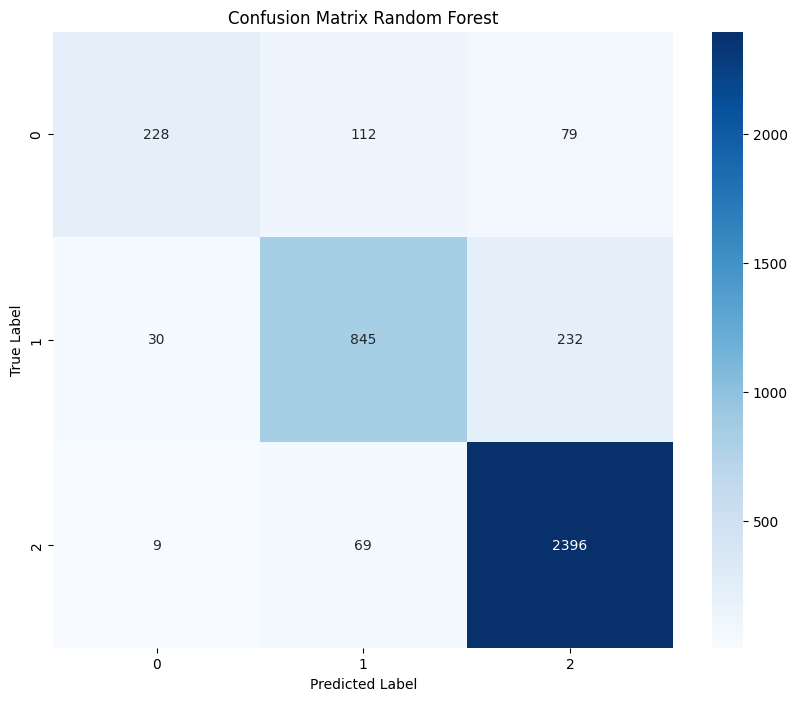

In [69]:
label_pred_rf2 = rf_model2.predict(fitur_test_rf2)
label_pred_train_rf2 = rf_model2.predict(fitur_train_rf2)

# Evaluasi pada data training
accuracy_train_rf2 = accuracy_score(label_train_rf2, label_pred_train_rf2)
print(f"Akurasi Training Random Forest: {accuracy_train_rf2}")
print("Classification Report Training Random Forest:")
print(classification_report(label_train_rf2, label_pred_train_rf2))

# Evaluasi pada data testing
accuracy_rf2 = accuracy_score(label_test_rf2, label_pred_rf2)
print(f"Akurasi Testing Random Forest: {accuracy_rf2}")
print("Classification Report Testing Random Forest:")
print(classification_report(label_test_rf2, label_pred_rf2))

# Membuat Confusion Matrix
cm_rf2 = confusion_matrix(label_test_rf2, label_pred_rf2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **LSTM x TF-IDF (70/20/10)**

### **Praprocessing Teks untuk Model LSTM Menggunakan TF-IDF (70/20/10)**

In [70]:
# Menginisialisasi tokenizer dan membatasi jumlah kata unik sebanyak 10.000
tokenizer = Tokenizer(num_words=10000)

# Menyesuaikan tokenizer dengan teks yang telah dibersihkan
tokenizer.fit_on_texts(fitur)

# Mengubah teks menjadi urutan angka berdasarkan kamus tokenizer
fitur_sekuensial = tokenizer.texts_to_sequences(fitur)

# Menyamakan panjang urutan dengan padding (maksimal 100 kata)
fitur_padat = pad_sequences(fitur_sekuensial, maxlen=100)

In [71]:
jumlah_kelas = len(np.unique(label))
print(f"Jumlah kelas: {jumlah_kelas}")

# Menampilkan dimensi dari fitur hasil padding
print(f"Dimensi urutan fitur: {fitur_padat.shape}")

# Menampilkan ukuran kosa kata dari tokenizer
kosa_kata_index = tokenizer.word_index
print(f"\nUkuran kosa kata: {len(kosa_kata_index)} kata")

Jumlah kelas: 3
Dimensi urutan fitur: (19996, 100)

Ukuran kosa kata: 10058 kata


### **Pelatihan dan Prediksi Model LSTM**

In [72]:
fitur_latih_lstm, fitur_uji_lstm, label_latih_lstm, label_uji_lstm = train_test_split(
    fitur_padat, label, test_size=0.2, random_state=42
)

# Mengambil 10% dari 80% data latih sebagai data validasi (0.1 / 0.8 = 0.125)
fitur_latih_lstm, fitur_validasi_lstm, label_latih_lstm, label_validasi_lstm = train_test_split(
    fitur_latih_lstm, label_latih_lstm, test_size=0.125, random_state=42
)

# Menampilkan jumlah sampel di setiap subset
print("Total Sampel:")
print(f"Set pelatihan: {fitur_latih_lstm.shape[0]} sampel")
print(f"Set validasi : {fitur_validasi_lstm.shape[0]} sampel")
print(f"Set pengujian: {fitur_uji_lstm.shape[0]} sampel")

Total Sampel:
Set pelatihan: 13996 sampel
Set validasi : 2000 sampel
Set pengujian: 4000 sampel


In [73]:
# Membuat model LSTM untuk klasifikasi sentimen
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),       # Representasi kata dalam vektor
    SpatialDropout1D(0.4),                                               # Dropout untuk regularisasi
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),                       # LSTM untuk memahami urutan kata
    Dense(3, activation='softmax')                                       # Output 3 kelas sentimen
])

# Menyusun model dengan loss dan optimizer
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Callback untuk kontrol pelatihan
callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
callback_lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

# Daftar callback
callbacks = [callback_early_stopping, callback_lr_reduction]

# Menjalankan pelatihan model
riwayat_latihan = model_lstm.fit(
    fitur_latih_lstm, label_latih_lstm,
    validation_data=(fitur_validasi_lstm, label_validasi_lstm),
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 348ms/step - accuracy: 0.6800 - loss: 0.7407 - val_accuracy: 0.9170 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 345ms/step - accuracy: 0.9261 - loss: 0.2090 - val_accuracy: 0.9500 - val_loss: 0.1564 - learning_rate: 0.0010
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 80s 335ms/step - accuracy: 0.9655 - loss: 0.0962 - val_accuracy: 0.9570 - val_loss: 0.1392 - learning_rate: 0.0010
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 344ms/step - accuracy: 0.9816 - loss: 0.0573 - val_accuracy: 0.9560 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 338ms/step - accuracy: 0.9906 - loss: 0.0302 - val_accuracy: 0.9600 - val_loss: 0.1396 - learning_rate: 0.0010


### **Evaluasi Model LSTM dengan TF-IDF**

438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Laporan Klasifikasi (Data Latih):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1401
           1       0.97      0.98      0.97      3953
           2       1.00      0.99      0.99      8642

    accuracy                           0.99     13996
   macro avg       0.98      0.98      0.98     13996
weighted avg       0.99      0.99      0.99     13996

Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       201
           1       0.91      0.94      0.93       550
           2       0.98      0.98      0.98      1249

    accuracy                           0.96      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.96      0.96      0.96      2000



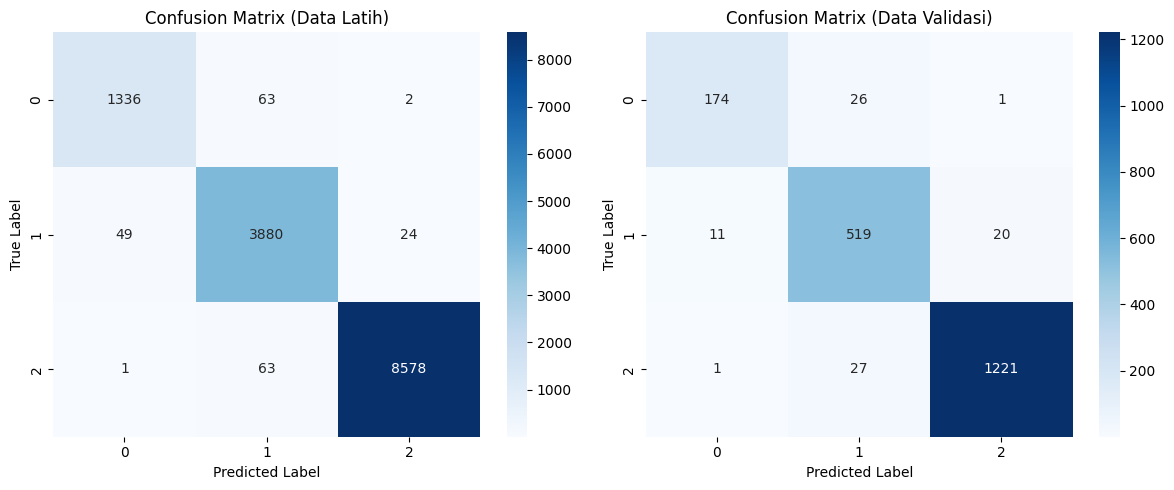

In [74]:
# Prediksi Label untuk Data Uji
prediksi_latih_lstm = model_lstm.predict(fitur_latih_lstm)
prediksi_latih_lstm = np.argmax(prediksi_latih_lstm, axis=1) # Mengambil indeks kelas dengan probabilitas tertinggi

prediksi_validasi_lstm = model_lstm.predict(fitur_validasi_lstm)
prediksi_validasi_lstm = np.argmax(prediksi_validasi_lstm, axis=1) # Mengambil indeks kelas dengan probabilitas tertinggi

# Laporan Klasifikasi
print("Laporan Klasifikasi (Data Latih):")
print(classification_report(label_latih_lstm, prediksi_latih_lstm))

print("Laporan Klasifikasi (Data Validasi):")
print(classification_report(label_validasi_lstm, prediksi_validasi_lstm))

# Confusion Matrix
cm_latih_lstm = confusion_matrix(label_latih_lstm, prediksi_latih_lstm)
cm_validasi_lstm = confusion_matrix(label_validasi_lstm, prediksi_validasi_lstm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_latih_lstm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Data Latih)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(cm_validasi_lstm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Data Validasi)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

## **Bag of Words Module**

In [75]:
# Load Data
ulasan_bow = pd.read_csv('data_bersih_berlabel.csv')

In [76]:
ulasan_bow.head()

,content,score,word_count,clean_content,casefold_content,tokens,stemmed_tokens,tokens_negation,tokens_slang,stopword_removal,sentiment_label,sentiment_score
0,Tambahin fitur keamanannnya dong bang operator,2,6,Tambahin fitur keamanannnya dong bang operator,tambahin fitur keamanannnya dong bang operator,"['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambahin', 'fitur', 'keamanannnya', 'dong', ...","['tambah', 'fitur', 'keamanannnya', 'dong', 'b...","['fitur', 'keamanannnya', 'bang', 'operator']",netral,0
1,Sangat baik,3,2,Sangat baik,sangat baik,"['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']","['sangat', 'baik']",[],netral,0
2,whatsapp sangat membantu saya dalam berkomunikasi,5,6,whatsapp sangat membantu saya dalam berkomunikasi,whatsapp sangat membantu saya dalam berkomunikasi,"['whatsapp', 'sangat', 'membantu', 'saya', 'da...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'sangat', 'bantu', 'saya', 'dalam...","['whatsapp', 'bantu', 'komunikasi']",positif,2
3,Top,4,1,Top,top,['top'],['top'],['top'],['top'],['top'],positif,1
4,Ok,5,1,Ok,ok,['ok'],['ok'],['ok'],['ok'],['ok'],positif,1


In [77]:
# Ekstrak Data untuk Klasifikasi
texts = ulasan_bow['stopword_removal'].tolist()
labels = ulasan_bow['sentiment_label'].tolist()

In [78]:
class BOWVectorizer:
    def __init__(self, max_features=5000):
        self.vectorizer = CountVectorizer(
            max_features=max_features
        )

    def fit_transform(self, texts):
        # Transformasi BoW
        bow_matrix = self.vectorizer.fit_transform(texts)

        return bow_matrix.toarray(), self.vectorizer.get_feature_names_out()

    def transform(self, texts):
        # Transformasi BoW
        bow_matrix = self.vectorizer.transform(texts)

        return bow_matrix.toarray()

## **N-Gram Module**

In [79]:
class NGramVectorizer:
    def __init__(self, ngram_range=(1,2), max_features=5000):
        self.vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features
        )

    def fit_transform(self, texts):
        # Transformasi N-Gram
        ngram_matrix = self.vectorizer.fit_transform(texts)

        return ngram_matrix.toarray(), self.vectorizer.get_feature_names_out()

    def transform(self, texts):
        # Transformasi N-Gram
        ngram_matrix = self.vectorizer.transform(texts)

        return ngram_matrix.toarray()

## **SVM x BoW (80/20)**

### **Praprocessing Teks untuk Model SVM Menggunakan BoW (80/20)**

In [80]:
texts_train_bow, texts_test_bow, label_train_bow, label_test_bow = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [81]:
# Inisialisasi BoW Vectorizer
bow_vectorizer = BOWVectorizer(max_features=10000)

In [82]:
# Transformasi data training menggunakan BoW
texts_bow_train, bow_features = bow_vectorizer.fit_transform(texts_train_bow)

# Transformasi data testing menggunakan BoW
texts_bow_test = bow_vectorizer.transform(texts_test_bow)

### **Pelatihan dan Prediksi Model SVM**

In [102]:
# Inisialisasi Linear SVM
linear_svm_bow = SVC(kernel='linear', class_weight='balanced')

In [103]:
# Latih model
linear_svm_bow.fit(texts_bow_train, label_train_bow)

SVC(class_weight='balanced', kernel='linear')

### **Evaluasi Model SVM dengan BoW**

In [104]:
# Prediksi
prediksi_latih_bow = linear_svm_bow.predict(texts_bow_train)
prediksi_uji_bow = linear_svm_bow.predict(texts_bow_test)

# Confusion Matrix
cm_latih_bow = confusion_matrix(label_train_bow, prediksi_latih_bow)
cm_uji_bow = confusion_matrix(label_test_bow, prediksi_uji_bow)

=== Evaluasi Model SVM Linear dengan BoW ===

Classification Report (Data Latih):
              precision    recall  f1-score   support

     negatif       0.99      1.00      1.00      1617
      netral       0.98      1.00      0.99      4488
     positif       1.00      0.99      0.99      9891

    accuracy                           0.99     15996
   macro avg       0.99      1.00      0.99     15996
weighted avg       0.99      0.99      0.99     15996


Classification Report (Data Uji):
              precision    recall  f1-score   support

     negatif       0.90      0.92      0.91       404
      netral       0.93      0.94      0.93      1122
     positif       0.99      0.98      0.98      2474

    accuracy                           0.96      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.96      0.96      0.96      4000



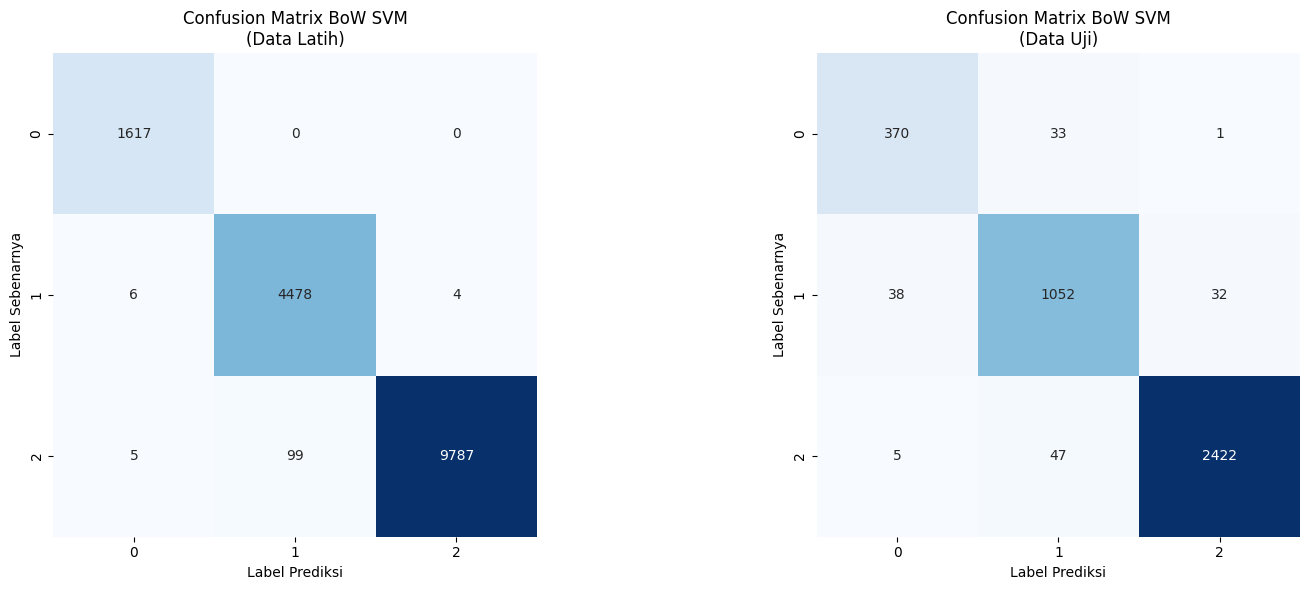

In [127]:
# Cetak Laporan Klasifikasi
print("=== Evaluasi Model SVM Linear dengan BoW ===")

print("\nClassification Report (Data Latih):")
print(classification_report(label_train_bow, prediksi_latih_bow))

print("\nClassification Report (Data Uji):")
print(classification_report(label_test_bow, prediksi_uji_bow))

# Confusion Matrix Data Latih
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_latih_bow, annot=True, fmt="d", cmap="Blues",
            square=True, cbar=False)
plt.title("Confusion Matrix BoW SVM\n(Data Latih)")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Sebenarnya")

# Confusion Matrix Data Uji
plt.subplot(1, 2, 2)
sns.heatmap(cm_uji_bow, annot=True, fmt="d", cmap="Blues",
            square=True, cbar=False)
plt.title("Confusion Matrix BoW SVM\n(Data Uji)")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Sebenarnya")

plt.tight_layout()
plt.show()

## **SVM x N-Gram (80/20)**

### **Praprocessing Teks untuk Model SVM Menggunakan N-Gram (80/20)**

In [87]:
# Split data training dan testing (80/20)
texts_train_ngram, texts_test_ngram, label_train_ngram, label_test_ngram = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [110]:
# Inisialisasi N-Gram Vectorizer (Unigram + Bigram)
ngram_vectorizer = NGramVectorizer(
    ngram_range=(1,2),
    max_features=2000
)

In [111]:
# Transformasi data training menggunakan N-Gram
texts_ngram_train, ngram_features = ngram_vectorizer.fit_transform(texts_train_ngram)

# Transformasi data testing menggunakan N-Gram
texts_ngram_test = ngram_vectorizer.transform(texts_test_ngram)

### **Pelatihan dan Prediksi Model SVM**

In [112]:
# Pelatihan Model SVM Linear untuk N-Gram
linear_svm_ngram = SVC(kernel='linear', class_weight='balanced')
linear_svm_ngram.fit(texts_ngram_train, label_train_ngram)

SVC(class_weight='balanced', kernel='linear')

In [113]:
# Prediksi
prediksi_latih_ngram = linear_svm_ngram.predict(texts_ngram_train)
prediksi_uji_ngram = linear_svm_ngram.predict(texts_ngram_test)

### **Evaluasi Model SVM dengan N-Gram**

=== Evaluasi Model SVM Linear dengan N-Gram ===

Classification Report (Data Latih):
              precision    recall  f1-score   support

     negatif       0.87      0.95      0.91      1617
      netral       0.91      0.95      0.93      4488
     positif       0.99      0.96      0.98      9891

    accuracy                           0.96     15996
   macro avg       0.93      0.95      0.94     15996
weighted avg       0.96      0.96      0.96     15996


Classification Report (Data Uji):
              precision    recall  f1-score   support

     negatif       0.81      0.87      0.84       404
      netral       0.87      0.91      0.89      1122
     positif       0.98      0.95      0.97      2474

    accuracy                           0.93      4000
   macro avg       0.89      0.91      0.90      4000
weighted avg       0.94      0.93      0.93      4000



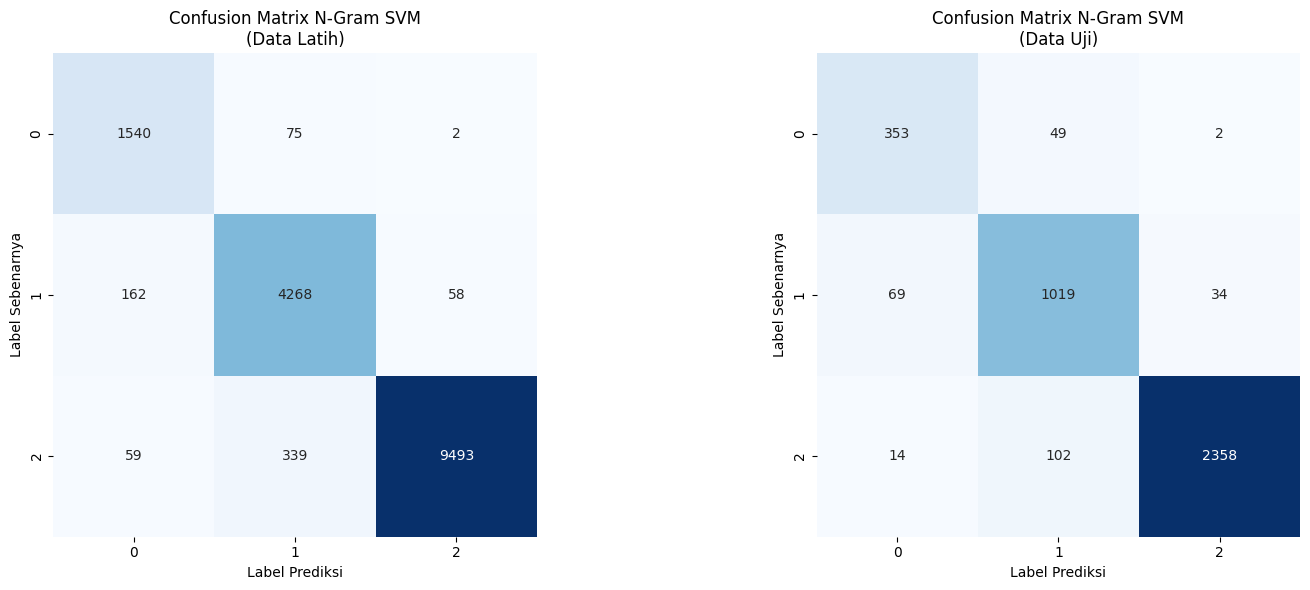

In [114]:
# Confusion Matrix
cm_latih_ngram = confusion_matrix(label_train_ngram, prediksi_latih_ngram)
cm_uji_ngram = confusion_matrix(label_test_ngram, prediksi_uji_ngram)

# Cetak Laporan Klasifikasi
print("=== Evaluasi Model SVM Linear dengan N-Gram ===")

print("\nClassification Report (Data Latih):")
print(classification_report(label_train_ngram, prediksi_latih_ngram))

print("\nClassification Report (Data Uji):")
print(classification_report(label_test_ngram, prediksi_uji_ngram))

# Visualisasi Confusion Matrix
plt.figure(figsize=(16, 6))

# Confusion Matrix Data Latih
plt.subplot(1, 2, 1)
sns.heatmap(cm_latih_ngram, annot=True, fmt="d", cmap="Blues",
            square=True, cbar=False)
plt.title("Confusion Matrix N-Gram SVM\n(Data Latih)")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Sebenarnya")

# Confusion Matrix Data Uji
plt.subplot(1, 2, 2)
sns.heatmap(cm_uji_ngram, annot=True, fmt="d", cmap="Blues",
            square=True, cbar=False)
plt.title("Confusion Matrix N-Gram SVM\n(Data Uji)")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Sebenarnya")

plt.tight_layout()
plt.show()

## **Menyimpan Model**

In [130]:
# Simpan Model TF-IDF
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Simpan Model SVM x TF-IDF (80/20)
with open('svm_tfidf_8020_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Simpan Model SVM x TF-IDF (60/40)
with open("svm_tfidf_6040_model.pkl", "wb") as f:
    pickle.dump(svm_model2, f)

# Simpan Model RF x TF-IDF (70/30)
with open("rf_tfidf_7030_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Simpan Model RF x TF-IDF (80/20)
with open("rf_tfidf_8020_model.pkl", "wb") as f:
    pickle.dump(rf_model2, f)

# Simpan Model LSTM x TF-IDF (80/20)
model_lstm.save("lstm_tfidf_702010_model.h5")

# Simpan Model Bag of Words
with open('bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(BOWVectorizer, f)

# Simpan Model N-Gram
with open("ngram_model.pkl", "wb") as f:
    pickle.dump(NGramVectorizer, f)

# Simpan Model SVM x BoW (80/20)
with open("svm_bow_8020_model.pkl", "wb") as f:
    pickle.dump(linear_svm_bow, f)

# Simpan Model SVM x N-Gram (80/20)
with open("svm_ngram_8020_model.pkl", "wb") as f:
    pickle.dump(linear_svm_ngram, f)

## Requirements

In [131]:
pip freeze > requirements.txt